In [1]:
import os
import logging
import pandas as pd
import numpy as np


BASE_DIR = "/Users/kelstonchen/GitRepos/predicting_race_winners"

In [25]:
COLUMNS = [
    'position', 
#     'points', 
    'grid', 
    'status', 
    'Driver.driverId', 
    'Constructor.constructorId', 
    'Time.millis', 
    'season', 
    'round', 
    'circuit'
    ]

In [ ]:
def define_points(df):
    """
    Redefine points system, every place get at least 1 point 
    add/subtract points based on difference between start and end position (grid - position).

    Set points to zero if driver did not finish, or else points could be negative.
    """
    finished = (df['status'] == 'Finished')
    base_points = np.abs(df['position'] - df['position'].max()) + 1
    position_change = np.where(
        df['grid'] > 0, 
        (df['grid'] - df['position']), 
        (20 - df['position']) # if starting from PL, assume driver starts from last place
        )
    
    points = (base_points + position_change) * finished # points = 0 if driver did not finish
    return points

def create_points_time(df):

    by_race = df.groupby(['season', 'round'])

    # Standardize time (z-score)
    df['std_time'] = (df['Time.millis'] - by_race['Time.millis'].transform('mean')) / by_race['Time.millis'].transform('std')

    # Scale points by standardized time, square it to keep it > 0
    df['points_time'] = df['points'] * df['std_time']
    
    return df

In [46]:
results = pd.read_csv(os.path.join(BASE_DIR, 'data', 'intermediate', 'results', 'results.csv'))
results = results.loc[:, COLUMNS]

results['points'] = define_points(results)
results = create_points_time(results)

In [47]:
results

,position,grid,status,Driver.driverId,Constructor.constructorId,Time.millis,season,round,circuit,points,std_time,points_time
0,1,1,Finished,leclerc,ferrari,5853584.0,2022,1,bahrain,20,-1.409746,-28.194914
1,2,3,Finished,sainz,ferrari,5859182.0,2022,1,bahrain,20,-1.147680,-22.953609
2,3,5,Finished,hamilton,mercedes,5863259.0,2022,1,bahrain,20,-0.956819,-19.136388
3,4,9,Finished,russell,mercedes,5864795.0,2022,1,bahrain,22,-0.884913,-19.468085
4,5,7,Finished,kevin_magnussen,haas,5868338.0,2022,1,bahrain,18,-0.719051,-12.942912
...,...,...,...,...,...,...,...,...,...,...,...,...
1434,16,17,Finished,lawson,rb,5803870.0,2025,4,bahrain,6,1.149746,6.898477
1435,17,19,Finished,stroll,aston_martin,5804924.0,2025,4,bahrain,6,1.203608,7.221649
1436,18,18,Finished,bortoleto,sauber,5806307.0,2025,4,bahrain,3,1.274283,3.822849
1437,19,8,Retired,sainz,williams,NaN,2025,4,bahrain,0,NaN,NaN


<Axes: xlabel='points_time', ylabel='round'>

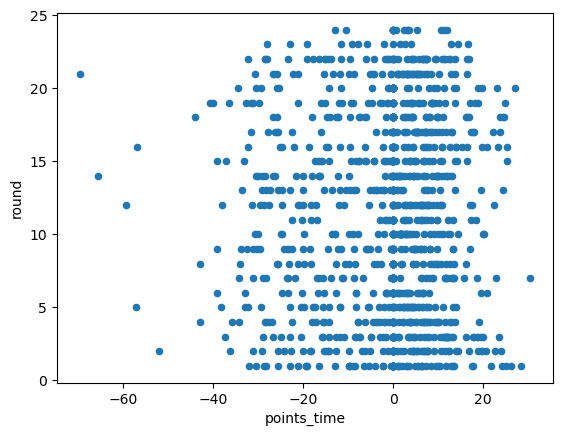

In [48]:
results.plot(kind='scatter', y='round', x='points_time')

In [49]:
results.groupby('Driver.driverId')['points_time'].mean().sort_values()

Driver.driverId
max_verstappen    -24.421030
leclerc           -11.438911
perez              -9.279318
sainz              -7.587819
norris             -7.323513
antonelli          -6.823506
hamilton           -5.689770
russell            -5.289429
piastri            -4.513668
alonso              0.044918
de_vries            1.172701
bortoleto           1.274283
hadjar              2.998170
sargeant            3.120504
bottas              3.305168
ocon                3.435542
ricciardo           4.070018
zhou                4.271589
kevin_magnussen     4.302323
gasly               4.525150
hulkenberg          5.041584
albon               5.375050
tsunoda             5.437422
mick_schumacher     6.685638
vettel              6.940127
stroll              7.111913
lawson              7.384281
doohan              8.482886
bearman             9.075841
latifi              9.704520
colapinto          10.165190
Name: points_time, dtype: float64

In [50]:
team_results = results.groupby(['season', 'round', 'Constructor.constructorId']).agg({'Time.millis': 'mean', 'points': 'sum'}).reset_index()
team_results = create_points_time(team_results)

In [51]:
team_results.groupby('Constructor.constructorId')['points_time'].mean().sort_values()

Constructor.constructorId
red_bull       -34.567953
ferrari        -20.537308
mercedes       -10.558025
mclaren        -10.294096
sauber           3.568878
alpine           4.894941
rb               5.453513
alfa             6.953708
alphatauri       7.102039
aston_martin     7.737584
williams         8.194836
haas             8.358069
Name: points_time, dtype: float64

In [52]:
key_fields = ['season', 'round', 'Constructor.constructorId']
results_final = results.merge(team_results[key_fields + ['points_time']], how='left', on=key_fields, suffixes=('_driver', '_team'))
results_final['points_proportion'] = results_final['points_time_driver'] / results_final['points_time_team']

In [56]:
results_final.groupby('Driver.driverId')['points_proportion'].mean().sort_values()

Driver.driverId
lawson            -63.238591
stroll             -0.674771
perez              -0.662168
ricciardo          -0.633804
antonelli           0.147592
russell             0.199654
piastri             0.275391
bottas              0.388753
de_vries            0.417116
kevin_magnussen     0.418679
sainz               0.431000
bearman             0.498065
leclerc             0.498659
bortoleto           0.501889
ocon                0.516301
alonso              0.521049
sargeant            0.533194
mick_schumacher     0.574792
zhou                0.624116
gasly               0.659530
doohan              0.719798
latifi              0.761269
hulkenberg          0.765104
tsunoda             0.889428
hamilton            0.939902
max_verstappen      1.053206
albon               1.230248
norris              1.636400
colapinto           1.681113
hadjar              3.332392
vettel              6.555774
Name: points_proportion, dtype: float64

In [57]:
results_final.loc[results_final['Driver.driverId'] == 'lawson']

,position,grid,status,Driver.driverId,Constructor.constructorId,Time.millis,season,round,circuit,points,std_time,points_time_driver,points_time_team,points_proportion
692,13,19,Finished,lawson,alphatauri,8670558.0,2023,13,zandvoort,14,0.557691,7.807669,21.451505,0.363968
710,11,12,Finished,lawson,alphatauri,4491781.0,2023,14,monza,11,0.872158,9.593740,8.704009,1.102221
728,9,10,Finished,lawson,alphatauri,6463336.0,2023,15,marina_bay,13,0.525559,6.832272,6.051523,1.129017
750,11,11,Lapped,lawson,alphatauri,5461510.0,2023,16,suzuka,0,-1.148305,-0.000000,-0.000000,NaN
766,17,17,Lapped,lawson,alphatauri,5286276.0,2023,17,losail,0,-0.470900,-0.000000,-0.000000,NaN
1247,9,19,Finished,lawson,rb,5780202.0,2024,19,americas,22,1.126800,24.789601,-0.034185,-725.154709
1274,16,12,Lapped,lawson,rb,6120266.0,2024,20,rodriguez,0,1.029066,0.000000,0.000000,NaN
1287,9,5,Finished,lawson,rb,7664882.0,2024,21,interlagos,8,0.335949,2.687590,1.112342,2.416155
1313,16,14,Finished,lawson,rb,5016974.0,2024,22,vegas,3,1.469062,4.407187,14.317527,0.307818
1332,14,17,Finished,lawson,rb,5527979.0,2024,23,losail,10,1.667870,16.678697,40.267577,0.414197


In [ ]:
# def quantile_time(df):
#     df['Time.millis']

results.groupby()['Time.millis']

,position,grid,status,Driver.driverId,Constructor.constructorId,Time.millis,season,round,circuit,points,std_time,points_time
0,1,1,Finished,leclerc,ferrari,5853584.0,2022,1,bahrain,20,-1.409746,-28.194914
1,2,3,Finished,sainz,ferrari,5859182.0,2022,1,bahrain,20,-1.147680,-22.953609
2,3,5,Finished,hamilton,mercedes,5863259.0,2022,1,bahrain,20,-0.956819,-19.136388
3,4,9,Finished,russell,mercedes,5864795.0,2022,1,bahrain,22,-0.884913,-19.468085
4,5,7,Finished,kevin_magnussen,haas,5868338.0,2022,1,bahrain,18,-0.719051,-12.942912
...,...,...,...,...,...,...,...,...,...,...,...,...
1434,16,17,Finished,lawson,rb,5803870.0,2025,4,bahrain,6,1.149746,6.898477
1435,17,19,Finished,stroll,aston_martin,5804924.0,2025,4,bahrain,6,1.203608,7.221649
1436,18,18,Finished,bortoleto,sauber,5806307.0,2025,4,bahrain,3,1.274283,3.822849
1437,19,8,Retired,sainz,williams,NaN,2025,4,bahrain,0,NaN,NaN
